In [193]:
#
# 売り出来高、買い出来高の推移
#
%matplotlib inline
import datetime
import pymongo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.finance as mf
from matplotlib.dates import date2num

In [232]:
import yaml
f = open('default.yaml', 'r+')
config = yaml.load(f)
f.close()
mongo_url = 'mongodb://' + config['mongo_user'] + ':' + config['mongo_pwd'] + '@' + config['mongo_host'] + ':' + config['mongo_port'] + '/' + config['mongo_db']

In [233]:
client = pymongo.MongoClient(mongo_url)
db = client.bitflyer
co = db.lightning_executions_FX_BTC_JPY_OHLC_300
#co = db.lightning_executions_FX_BTC_JPY_OHLC_3600
#co = db.lightning_executions_BTC_JPY_OHLC_86400
#co = db.lightning_executions_BCH_BTC_OHLC_300

In [234]:
date=[]
quote = []
volume_sell = []
volume_buy = []
volume_buy_avg1 = []
volume_sell_sum1 = []
volume_buy_sum1 = []
volume_sum1 = 12
volume_buy_avg2 = []
volume_sell_sum2 = []
volume_buy_sum2 = []
volume_sum2 = 24

#open_dateがafter以降のデータ
#after = datetime.datetime(2017,6,11)
#for data in co.find({'open_date':{'$gte':after}}).sort('id',1):

#直近のデータ400件
count = 600
skip = 0
if (co.count() > count):
    skip = co.count() - count
else:
    count = co.count()
for data in co.find({}).skip(skip).sort('id',1):
    t = data['op_date'] + datetime.timedelta(hours=9)
    date.append(t)
    quote.append((date2num(t), data['op'], data['cl'], data['hi'], data['lo']))
    volume_sell.append(data['vol_sell']/(data['vol_sell']+data['vol_buy']))
    volume_buy.append(data['vol_buy']/(data['vol_sell']+data['vol_buy']))
    
    volume_sell_sum1.append(data['vol_sell'])
    volume_buy_sum1.append(data['vol_buy'])    
    if (len(volume_sell_sum1) > volume_sum1):
        volume_sell_sum1.pop(0)
    if (len(volume_buy_sum1) > volume_sum1):
        volume_buy_sum1.pop(0)
    total = sum(volume_buy_sum1) + sum(volume_sell_sum1)
    volume_buy_avg1.append(sum(volume_buy_sum1)/total)
    
    volume_sell_sum2.append(data['vol_sell'])
    volume_buy_sum2.append(data['vol_buy'])    
    if (len(volume_sell_sum2) > volume_sum2):
        volume_sell_sum2.pop(0)
    if (len(volume_buy_sum2) > volume_sum2):
        volume_buy_sum2.pop(0)
    total = sum(volume_buy_sum2) + sum(volume_sell_sum2)
    volume_buy_avg2.append(sum(volume_buy_sum2)/total)


In [235]:
# figure_width := ローソク足チャート全体の幅 (単位:日)
# candle_width := ローソクの幅 (単位:日)
delta = date[-1] - date[0]
figure_width = delta.total_seconds()/(60*60*24)
candle_width = 0.6 * figure_width / count;

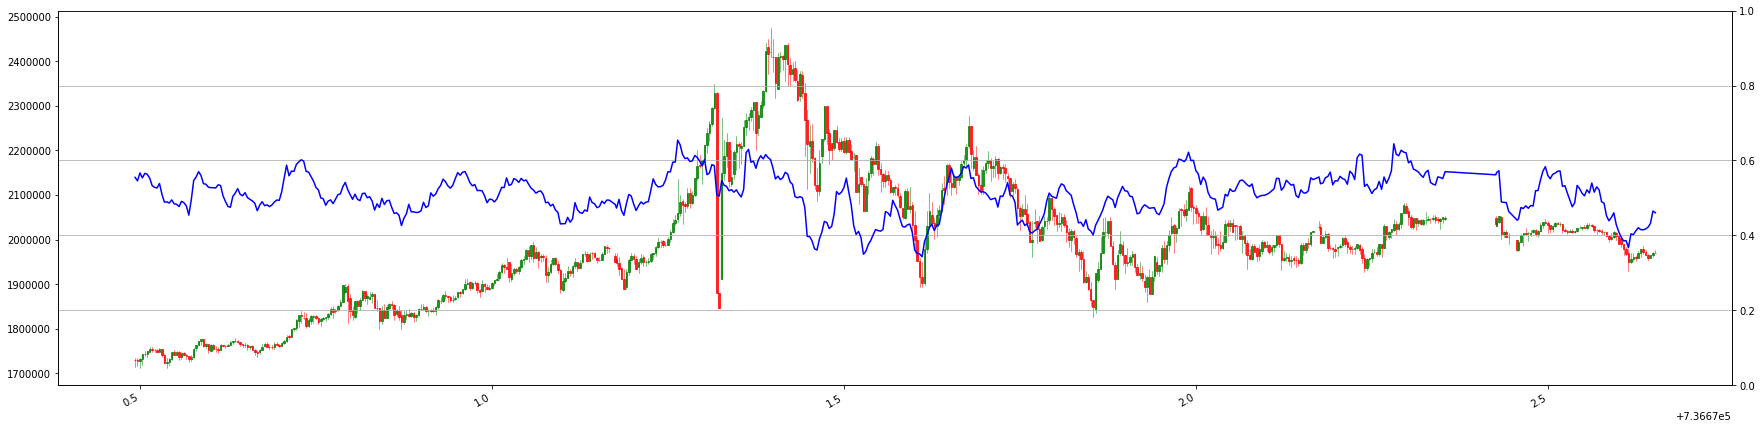

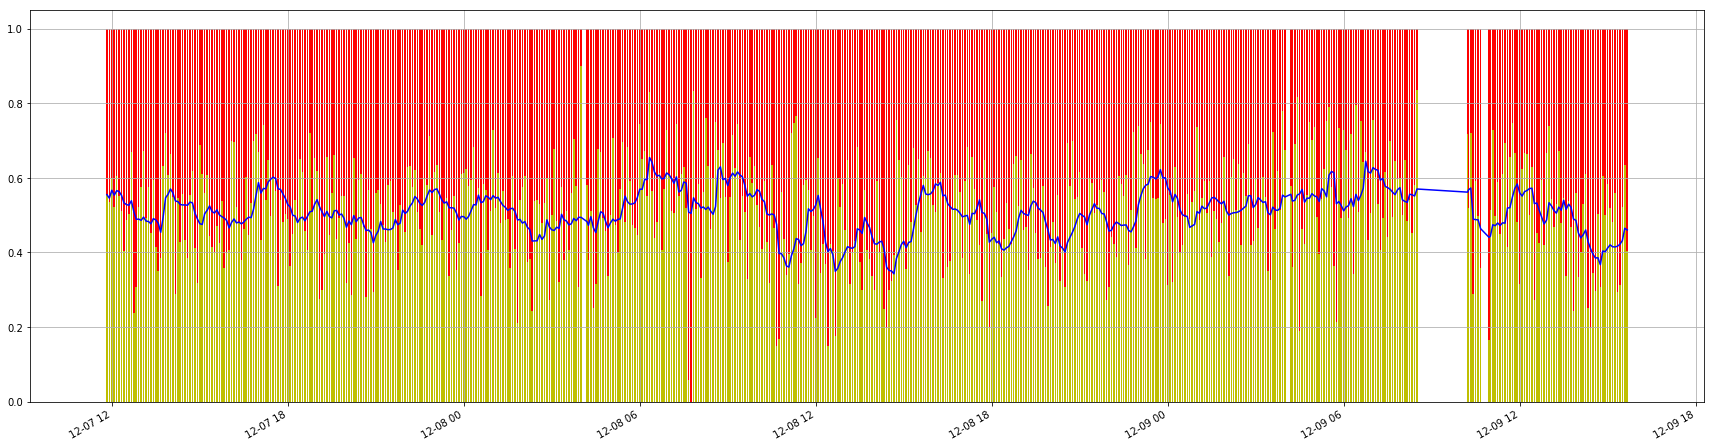

In [236]:
# ローソク足チャートを描く
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
#ax.grid()
#ax.set_xlim(date[0], date[-1])
mf.candlestick_ochl(ax, quote, width=candle_width, colorup='g', colordown='r', alpha=0.75)
ax2 = ax.twinx()
ax2.plot(date, volume_buy_avg1, color='b')
ax2.set_ylim(0,1.0)
ax2.grid()
fig.autofmt_xdate()

# 出来高の棒グラフを描く（赤＝売り、黄＝買い）
fig = plt.figure(figsize=(30, 8))
ax = fig.add_subplot(111)
ax.grid()
#ax.set_xlim(date[0], date[-1])
ax.bar(date, volume_buy, width=candle_width, color='y')
ax.bar(date, volume_sell, bottom=volume_buy, width=candle_width, color='r')
ax.plot(date, volume_buy_avg1, color='b')
#ax.plot(date, volume_buy_avg2, color='g')
fig.autofmt_xdate()

plt.show()
